In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('model.csv')

In [4]:
df.head()

,Unnamed: 0,sim_content,sin_comment,word_count,duplicate_word_ratio,no_of_sentences,length_of_comment,num_of_punctuations,is_period_sequence,stop_word_ratio,post_coment_gap,black_word_count,is_link,is_youtube_link,is_number,is_mail,comment_duplication,classifier_val
0,0,0.372249,0.280355,3.057751,0.083333,3,6.612096,4.0,0,0.000000,8.750086,1.0,1,0,0,0,0.000000,1
1,1,0.354255,0.341604,2.410947,0.000000,1,4.897796,1.0,0,0.000000,15.380144,2.0,0,0,0,0,0.715092,0
2,2,0.487752,0.314966,1.578192,0.000000,1,3.791178,0.0,0,0.000000,14.181022,0.0,0,0,0,0,0.000000,0
3,3,0.468095,0.368193,2.328976,0.000000,1,5.041488,0.0,0,0.090909,13.636652,2.0,0,0,0,0,0.000000,0
4,4,0.366191,0.258061,2.238987,0.000000,1,5.174158,4.0,0,0.000000,13.529500,0.0,1,1,0,0,0.000000,0


In [5]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sin_comment', 'word_count',
       'duplicate_word_ratio', 'no_of_sentences', 'length_of_comment',
       'num_of_punctuations', 'is_period_sequence', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'is_link', 'is_youtube_link',
       'is_number', 'is_mail', 'comment_duplication', 'classifier_val'],
      dtype='object')

#### Standardization  is no need for gb

In [6]:
dfc = df.copy()

In [7]:
y = dfc['classifier_val']
X = dfc.drop(['classifier_val','id'],axis=1)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Handle imbalnce dataset (here we gonna use oversampling instead of smotec)

In [10]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(0.9)
X_train_ns,y_train_ns=os.fit_sample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

X_train = X_train_ns
y_train = y_train_ns

The number of classes before fit Counter({0: 1778, 1: 409})
The number of classes after fit Counter({0: 1778, 1: 1600})


C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.9 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


#### Hyperparameter Tuninng

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
gb = GradientBoostingClassifier()

In [13]:
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [14]:
grid={
    'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
    'n_estimators':[100,250,500,750,1000,1250,1500,1750],
    'max_depth':[2,3,4,5,6,7],
    'min_samples_split':[2,4,6,8,10,20,40,60,100], 
    'min_samples_leaf':[1,3,5,7,9],
    'max_features':[2,3,4,5,6,7],
    'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
}

In [15]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
gb_random = RandomizedSearchCV(estimator=gb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [17]:
gb_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 22.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=GradientBoostingClassifier(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.15, 0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                                        'max_depth': [2, 3, 4, 5, 6, 7],
                                        'max_features': [2, 3, 4, 5, 6, 7],
                                        'min_samples_leaf': [1, 3, 5, 7, 9],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              20, 40, 60, 100],
                                        'n_estimators': [100, 250, 500, 750,
                                                         1000, 1250, 1500,
                                                         1750],
                                        'subs

In [ ]:
#### Evaluvate

In [19]:
best_model = gb_random.best_estimator_

In [20]:
best_model

GradientBoostingClassifier(learning_rate=0.15, max_depth=7, max_features=3,
                           min_samples_leaf=3, min_samples_split=6,
                           n_estimators=1750, subsample=0.75)

In [21]:
gb_random.best_params_

{'subsample': 0.75,
 'n_estimators': 1750,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_features': 3,
 'max_depth': 7,
 'learning_rate': 0.15}

In [22]:
gb_random.best_score_

0.9837225431496147

In [23]:
y_pred = best_model.predict(X_test)

In [24]:
err  =(y_pred- y_test)

<AxesSubplot:>

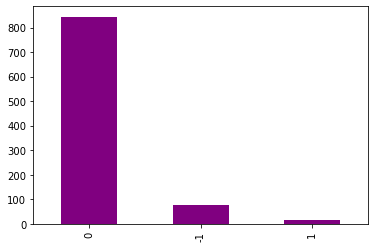

In [25]:
err.value_counts().plot(kind='bar',color='purple')

In [26]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.10021321961620469
MSE: 0.10021321961620469
RMSE: 0.3165647163159607


Text(0, 0.5, 'Feature Importance Score')

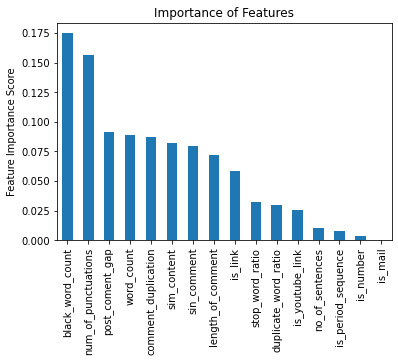

In [28]:
indices=list(X_train)
feat_imp = pd.Series(best_model.feature_importances_, indices).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[746  16]
 [ 78  98]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       762
           1       0.86      0.56      0.68       176

    accuracy                           0.90       938
   macro avg       0.88      0.77      0.81       938
weighted avg       0.90      0.90      0.89       938



In [32]:
print("accuracy is {}".format(best_model.score(X_test, y_test)))

accuracy is 0.8997867803837953


In [30]:
#import pickle
# open a file, where you ant to store the data
#file = open('random_forest_regression_model_v2.pkl', 'wb')
# dump information to that file
#pickle.dump(rf_random, file)